# CFPB Credit Card Plan Surveys Notebook

1. [Jump to Imports and Ingest](#import_ingest)
2. [Jump to Beginning of EDA](#EDA_Header)
3. [Jump to Item v. Unit Missingness](#missingness)
4. [Jump to Cleaning Null Values](#cleaning_nulls)
    - [Jump to Cleaning Plan_Name](#plane-name)
    - [Jump to Cleaning Availability of Credit Card Plans](#available)
    - [Jump to Cleaning Location](#location)
    - [Jump to Cleaning APR](#apr)
    - [Jump to Cleaning Index](#index)
    - [Jump to Cleaning Variable Rate Index](#vari)
    - [Jump to Cleaning Grace Period & Telephone Number](#gp-tn)
    - [Jump to Cleaning Annual & Late Fees](#annual_late)
5. [Jump to Exploratory Data Analysis](#EDA)
    - [Jump to EDA APR](#apr-plots)
    - [Supplemental Data EDA](#supplemental)
6. [Jump to Product](#product)

## Data Dictionary
|Feature|Type|Description|
|:---|:---:|:---:|
|**Agreement_Date**|*datetime*|6-month interval for a given year when this report was provided by participants|
|**Institution_Name**|*object*|The name of the Institution that issued the credit card plan.|
|**Plan_Name**|*object*|The name of the credit card plan.|
|**Availability_of_Credit_Card_Plan**|*object*|States whether the credit card is available nationally, regionally, or only in one state. Options include: National, Regional, and One State.|
|**Location**|*object*|If the credit card plan is available regionally or within a single state, the ‘Location’ column will list the state(s) in which the credit card plan is available. In the event the credit card plan is available nationally, the ‘Location’ cell will be null.|
|**APR**|*float64*|“Annual Percentage Rate” states the annualized interest rate that is used to compute finance charges for purchases. If the purchase APR for new customers varies by customer segment, the APR reported is the midpoint of the range of APRs offered to new customers of the product as of the reporting date.|
|**Index**|*object*|Displays V (variable) in the event the credit card plan’s interest rate is variable. If the credit card plan has a fixed interest rate, then the Index column will display F (fixed).|
|**Variable_Rate_Index**|*object*|If the credit card plan has a variable rate, the ’Variable Rate Index’ column shows the index used to set the rate. Options include: Prime, One-month T-bill, Three-month T-bill, Six-month T- bill, One-year T-bill, Fed Funds, Cost of Funds, Federal Reserve Discount Rate, and Other.|
|**Grace_Period**|*float64*|States the period of time from the end of the billing cycle in which credit extended for purchases during that billing cycle may be repaid without incurring a finance charge.|
|**Annual_Fee**|*float64*|Changed from "Annual Fee" for processing. The annual charge, expressed as an annualized amount, that is imposed for the issuance or availability of the credit card.|
|**Late_Fee**|*float64*|The fee imposed by an issuer for a late payment.|
|**Telephone_Number_for_Consumers**|*object*|The phone number where the institution in question can be reached.|

Source: https://cfpb.my.salesforce-sites.com/CreditCardPlanSurveys/resource/1600984878000/TccpPublicSiteQuickReferenceGuide (Page 4)

<a id="import_ingest"></a>

---
## Imports and Ingest

----

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
import networkx

In [7]:
tccp = pd.read_csv("../data/TCCP_Surveys.csv")

In [8]:
tccp.columns

Index(['Agreement Date', 'Institution Name', 'Plan Name',
       'Availability of Credit Card Plan', 'Location', 'APR', 'Index',
       'Variable Rate Index', 'Grace Period', 'Annual Fee', 'Late Fee',
       'Telephone Number for Consumers'],
      dtype='object')

In [9]:
tccp.columns = [col.replace(" ","_") for col in tccp.columns]

In [10]:
tccp.columns

Index(['Agreement_Date', 'Institution_Name', 'Plan_Name',
       'Availability_of_Credit_Card_Plan', 'Location', 'APR', 'Index',
       'Variable_Rate_Index', 'Grace_Period', 'Annual_Fee', 'Late_Fee',
       'Telephone_Number_for_Consumers'],
      dtype='object')

In [11]:
tccp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9556 entries, 0 to 9555
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Agreement_Date                    9556 non-null   object 
 1   Institution_Name                  9556 non-null   object 
 2   Plan_Name                         9552 non-null   object 
 3   Availability_of_Credit_Card_Plan  9551 non-null   object 
 4   Location                          8755 non-null   object 
 5   APR                               9522 non-null   float64
 6   Index                             9554 non-null   object 
 7   Variable_Rate_Index               5787 non-null   object 
 8   Grace_Period                      9474 non-null   float64
 9   Annual_Fee                        8011 non-null   float64
 10  Late_Fee                          2540 non-null   float64
 11  Telephone_Number_for_Consumers    9474 non-null   object 
dtypes: flo

In [13]:
tccp.isnull().sum().sum()

13340

Based on the data dictionary available, there is only 1 features where we knowingly expect NULL values:
- `Location`: If the credit card plan is available nationally, the cell will be listed as NULL

    
Below we will look to explore the other features with NULL values to:
- `Identify Unit Missingness` v. `Item Missingness`:
    - `Unit Missingness`: all values missing from an observation
    - `Item Missingness`: some but not all values are missing from an observation
- Define `MCAR`, `MAR`, `NMAR`:
    - `MCAR`: Missing Completely at Random
    - `MAR`: Missing at Random
    - `NMAR`: Not Missing at Random
- Decide on how to account for missing data

<a id="EDA_Header"></a>

---
## EDA - Exploration of Null Values/Clean

----

We'll keep a running tally for the amount of rows and cols we drop to ensure the amount we drop is less than 5% of the original total rows, and keep in mind features

In [93]:
total_null_rows_dropped = 0
total_null_cols_dropped = 0

### Null Count per feature

In [15]:
tccp.isnull().sum()

Agreement_Date                         0
Institution_Name                       0
Plan_Name                              4
Availability_of_Credit_Card_Plan       5
Location                             801
APR                                   34
Index                                  2
Variable_Rate_Index                 3769
Grace_Period                          82
Annual_Fee                          1545
Late_Fee                            7016
Telephone_Number_for_Consumers        82
dtype: int64

#### Total Rows

In [17]:
tccp.shape[0]

9556

<a id="missingness"></a>

----
### Unit Missingness v. Item Missingness


----

`Unit Missingness` can be ruled out simply by Agreement_Date and Institution_Date having no recorded NULL values <br>
`Item Missingness` by Feature:
- `Plan_Name`: **<~1% of rows are missing this value.** `MCAR`, each card is required to have a name, and given the volume of missing values (<~1%), this is most likely a data entry or systems error on the part of the institution who entered it.
- `Availability_of_Credit_Card_Plan`: **<~1% of rows are missing this value.** `MCAR`, similar logic as `Plan_Name`; an alternative could be a misunderstanding during data entry/collection with Location and these 5 have NULL instead of 'National', an easy check is checking if `Location` is NULL for these 5 rows.
- `Location`: **~8% of rows are missing this value.** `NMAR`, as mentioned above, this could simply mean we have 801 nationally available cards.
- `APR`: **<~1% of rows are missing this value.** `NMAR`, it's possible some of these offerings have 0% APR (doubt it), or an initial period of 0% APR.
- `Index`: **<~1% of rows are missing this value.** `MCAR`, similar logic to `Plan_Name`, and small  population (<~1%)
- `Variable_Rate_Index`: **~40% of rows are missing this value.** `NMAR`, as this field is only populated if the credit card has a variable rate. This will be dependent upon the `Index` feature. An easy check will be the number of rows where `Index` = "V".
- `Grace_Period`: **<~1% of rows are missing this value.** `NMAR`, dependent upon if the there is a grace period, if this data includes Charge Cards such as AMEX, there is no grace period and the bill is expected to be paid at the end of every month. We will check the different plan names v. these values to confirm that suspicion.
- `Annual_Fee`: **~16% of rows are missing this value.** NMAR, not all cards to my knowledge have Annual Fees
- `Late_Fee`: **~73% of rows are missing this value.** `Unsure`, the majority of credit card providers have late fees, including smaller banks and credit unions. According to CFPB there is an increasing but small percentage of companies that charge no late fees or offer products with increased flexibilioty for late payments (<a href="https://s3.amazonaws.com/files.consumerfinance.gov/f/documents/cfpb_credit-card-late-fees_report_2022-03.pdf">SOURCE</a> ), but even so I'd expect the reverse where a quarter of rows were missing this value. It might be worth it to translate this field into a boolean value depending on the variety of late fees and if they are all similar.
- `Telephone_Number_for_Consumers`: **<~1% of rows are missing this value.** `MCAR`, similar logic to `Plan_Name`
----

<a id="cleaning_nulls"></a>

## Cleaning of Null Values

In [26]:
tccp.isnull().sum()

Agreement_Date                         0
Institution_Name                       0
Plan_Name                              4
Availability_of_Credit_Card_Plan       5
Location                             801
APR                                   34
Index                                  2
Variable_Rate_Index                 3769
Grace_Period                          82
Annual_Fee                          1545
Late_Fee                            7016
Telephone_Number_for_Consumers        82
dtype: int64

Plan Name

<a id="plane-name"></a>

---
## Plan Name


---

In [36]:
tccp[tccp["Plan_Name"].isna()].head()

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
1478,2017-01-31,First National Bank Alaska,NaN,One State,AK,13.90,F,NaN,25.0,NaN,NaN,(800) 856-4362
3024,2012-07-31,"INTRUST BANK, NATIONAL ASSOCIATION",NaN,National,NaN,10.90,V,Prime,25.0,0.0,35.0,(800) 222-7458
3856,2009-07-31,HEARTLAND BANK,NaN,Single State,OH,11.65,V,Prime,25.0,18.0,NaN,(800) 697-0049
7068,1998-01-31,"FIRST OF AMERICA BANK, NATIONAL ASSOCIATION",NaN,National,N,15.40,V,Prime,25.0,0.0,NaN,(800) 423-3883


- Before filtering, I was hoping that the plan name would be an extension of the institution name.
- I looked up the most recent offerring which was First National Bank Alaska 2017, and they have multiple offerings now which makes it harder to fill in.
- Let's just check if there are other records with the Plan_Name Filled in

In [43]:
tccp[tccp["Institution_Name"] == "INTRUST BANK, NATIONAL ASSOCIATION"]["Plan_Name"].unique()

array(['VISA Platinum', 'VISA PLATINUM', nan, 'VISA REGULAR', 'VISA',
       'MASTERCARD/VISA', 'REGULAR MASTERCARD/VISA'], dtype=object)

In [44]:
tccp[tccp["Institution_Name"] == "First National Bank Alaska"]["Plan_Name"].unique()

array([nan, 'MasterCard'], dtype=object)

In [46]:
tccp[tccp["Institution_Name"] == "HEARTLAND BANK"]["Plan_Name"].unique()

array(['Classic Visa', 'MASTERCARD CLASSIC', 'CLASSIC MASTERCARD',
       'MASTERCARD', nan, 'MASTERCARD-CLASSIC', 'HEARTLAND BANK',
       'NAME OF PLAN: MASTERCARD', 'NAME OF THE CREDIT CARD PLAN: MASTER',
       'MASTER CARD'], dtype=object)

In [47]:
tccp[tccp["Institution_Name"] == "FIRST OF AMERICA BANK, NATIONAL ASSOCIATION"]["Plan_Name"].unique()

array(['MICHIGAN EDUCATION ASSOCIATION (MEA)', nan,
       'MICHIGAN ED ASSOC. (MEA) CLASSIC'], dtype=object)

- Ultimately only 4 records, for sake of time I will fill in for First National Bank Alaska which time wise is arguably the most relevant rates wise. Drop the rest until further notice

In [56]:
tccp[(tccp["Plan_Name"].isna()) & (tccp["Institution_Name"] == "First National Bank Alaska")]

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
1478,2017-01-31,First National Bank Alaska,NaN,One State,AK,13.9,F,NaN,25.0,NaN,NaN,(800) 856-4362


In [54]:
tccp.iloc[1478, 1]

'First National Bank Alaska'

In [58]:
tccp.iloc[1478, 2] = "MasterCard"

In [59]:
tccp[(tccp["Plan_Name"].isna()) & (tccp["Institution_Name"] == "First National Bank Alaska")]

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers


Success! Let's drop the rest for now

In [81]:
tccp[tccp["Plan_Name"].isna()]

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
3024,2012-07-31,"INTRUST BANK, NATIONAL ASSOCIATION",NaN,National,NaN,10.90,V,Prime,25.0,0.0,35.0,(800) 222-7458
3856,2009-07-31,HEARTLAND BANK,NaN,Single State,OH,11.65,V,Prime,25.0,18.0,NaN,(800) 697-0049
7068,1998-01-31,"FIRST OF AMERICA BANK, NATIONAL ASSOCIATION",NaN,National,N,15.40,V,Prime,25.0,0.0,NaN,(800) 423-3883


In [87]:
rows_to_drop = [index for index in tccp[tccp["Plan_Name"].isna()].index]

In [89]:
tccp.shape[0]

9556

In [90]:
tccp.drop(index=rows_to_drop,inplace=True)

In [91]:
tccp.shape[0]

9553

In [92]:
tccp[tccp["Plan_Name"].isna()]

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers


In [94]:
total_null_rows_dropped += 3

<a id="available"></a>

---
## Availability_of_Credit_Card_Plan


----

In [97]:
tccp[tccp["Availability_of_Credit_Card_Plan"].isna()]

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
1644,2016-07-31,Northwest Bank,Northwest Loyalty Visa,NaN,"MD, NY, OH, PA",7.99,V,Prime,25.0,0.0,0.0,NaN
1807,2016-01-31,Northwest Bank,Northwest Loyalty Visa,NaN,"MD, NY, OH, PA",7.74,V,Prime,25.0,0.0,0.0,NaN
1816,2016-01-31,Michigan State University Federal Credit Union,Platinum VISA,NaN,National,12.90,F,NaN,25.0,0.0,15.0,(800) 678-6967
1821,2016-01-31,Los Alamos National Bank,Visa,NaN,National,10.50,F,NaN,25.0,0.0,25.0,(800) 525-9634
1856,2016-01-31,Farmers & Merchants State Bank,MasterCard,NaN,National,15.99,F,NaN,25.0,NaN,NaN,(800) 451-7843


Simple Imputation here:
- Location can be null when the row is available nationally, in this instance our focus column is NaN but according to the Data Dictionary can also be National as an option.
- We'll check for other records of the other two to see if they say regional or other options to also impute
    - As seen below, safe assumption to impute regional based on other similar records

In [101]:
rows_to_alter = [index for index in tccp[(tccp["Availability_of_Credit_Card_Plan"].isna()) & (tccp["Institution_Name"] != "Northwest Bank")].index]

In [105]:
tccp.loc[rows_to_alter, "Availability_of_Credit_Card_Plan"] = "National"

In [118]:
# accidentally reran after the fact
# tccp[tccp["Availability_of_Credit_Card_Plan"].isna()].index

In [109]:
tccp[(tccp["Institution_Name"]=="Northwest Bank") & (tccp["Plan_Name"]=="Northwest Loyalty Visa")]

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
1270,2018-01-31,Northwest Bank,Northwest Loyalty Visa,Regional,"NY, OH, PA",8.99,V,Prime,0.0,25.0,35.0,(877) 300-5768
1360,2017-07-31,Northwest Bank,Northwest Loyalty Visa,Regional,"NY, OH, PA",8.74,V,Prime,25.0,0.0,35.0,(877) 300-5768
1450,2017-01-31,Northwest Bank,Northwest Loyalty Visa,Regional,"MD, NY, OH, PA",8.24,V,Prime,25.0,0.0,0.0,NaN
1644,2016-07-31,Northwest Bank,Northwest Loyalty Visa,NaN,"MD, NY, OH, PA",7.99,V,Prime,25.0,0.0,0.0,NaN
1807,2016-01-31,Northwest Bank,Northwest Loyalty Visa,NaN,"MD, NY, OH, PA",7.74,V,Prime,25.0,0.0,0.0,NaN


In [110]:
rows_to_alter = [index for index in tccp[tccp["Availability_of_Credit_Card_Plan"].isna()].index]

In [112]:
rows_to_alter

[1644, 1807]

In [113]:
tccp.loc[rows_to_alter, "Availability_of_Credit_Card_Plan"] = "Regional"

In [114]:
tccp[tccp["Availability_of_Credit_Card_Plan"].isna()]

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers


In [115]:
tccp.isnull().sum()

Agreement_Date                         0
Institution_Name                       0
Plan_Name                              0
Availability_of_Credit_Card_Plan       0
Location                             800
APR                                   34
Index                                  2
Variable_Rate_Index                 3769
Grace_Period                          82
Annual_Fee                          1545
Late_Fee                            7014
Telephone_Number_for_Consumers        82
dtype: int64

#### The below is after initial clean step, index is reset after the initial path through

In [311]:
tccp['Availability_of_Credit_Card_Plan'].unique()

array(['Regional', 'One State', 'National', 'Single State', '-', '#REF!'],
      dtype=object)

In [318]:
tccp[tccp['Availability_of_Credit_Card_Plan']=='#REF!']

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
2697,2013-01-31,KENTUCKY BANK,VISA,#REF!,KY,11.15,V,Prime,25.0,0.0,20.0,(800) 467-1939


In [322]:
tccp.iloc[2697]['Availability_of_Credit_Card_Plan']

'#REF!'

In [324]:
tccp.loc[[2697],['Availability_of_Credit_Card_Plan']] = "Single State"

In [326]:
rows_to_altar = tccp[tccp['Availability_of_Credit_Card_Plan']=='Single State'].index

In [329]:
tccp.loc[rows_to_altar,['Availability_of_Credit_Card_Plan']] = "One State"

In [330]:
tccp['Availability_of_Credit_Card_Plan'].unique()

array(['Regional', 'One State', 'National', '-'], dtype=object)

<a id="location"></a>

---
## Location
---

In [119]:
tccp[tccp["Availability_of_Credit_Card_Plan"]=="National"].shape

(4356, 12)

- okay there are 4356 nationally avaialble plans, and 800 null Locations (which again, can be null if available nationally.
- quick check to see if all 800 are included and a simple imputation and we can move on
    - RIP 471
    - additional dive to see other potential value imputations

In [121]:
tccp[(tccp["Availability_of_Credit_Card_Plan"]=="National") & (tccp["Location"].isna())].shape

(471, 12)

In [122]:
rows_to_alter = [index for index in tccp[(tccp["Availability_of_Credit_Card_Plan"]=="National") & (tccp["Location"].isna())].index]

In [125]:
len(rows_to_alter)

471

In [126]:
tccp.loc[rows_to_alter, "Location"] = "National"

In [127]:
tccp[tccp["Location"].isna()].shape

(329, 12)

In [129]:
len(tccp[tccp["Location"].isna()].index)

329

In [131]:
tccp.loc[tccp[tccp["Location"].isna()].index, "Availability_of_Credit_Card_Plan"].unique()

array(['Regional', 'One State'], dtype=object)

In [140]:
num_rows = tccp[(tccp["Availability_of_Credit_Card_Plan"]=="Regional") & (tccp["Location"].isna())].shape[0]

In [141]:
num_rows/tccp.shape[0]*100

2.208730241808856

- 211 rows is 2.2 % of total rows in our current set
- There's no simple path forward for finding the states for the plans, but thinking down the road, the states available I think will be nice to have and to save time let's drop for now and we can return later if need be to add them back
- Additionally one way to keep them to iterate over the unique combinations of Institution, Plan, and Region, and fill in values where location is not null

In [189]:
# Group the DataFrame by the specified columns
grouped = tccp.groupby(["Institution_Name", "Plan_Name", "Availability_of_Credit_Card_Plan"])

In [190]:
# Define a function to fill null values within each group with the first non-null value
def fillna_group(group):
    group["Location"] = group["Location"].fillna(method="ffill")
    return group

In [191]:
tccp = grouped.apply(fillna_group)

We reduced the Location NULL rows to 116 from 800, let's drop the rest and continue

In [193]:
tccp.dropna(subset=["Location"], inplace=True)

In [195]:
total_null_rows_dropped += 116

In [196]:
total_null_rows_dropped

119

<a id="apr"></a>

---
## APR
----

- considering there's only 34 missing APR and that APR is most likely a median of variable rates as per the data dictionary, let's impute the median because it is less affected by outliers than the mean.

In [198]:
tccp["APR"].fillna(tccp["APR"].median(), inplace=True)

<a id="index"></a>

---
## Index
----

In [201]:
tccp[tccp['Index'].isna()]

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
1386,2017-07-31,First State Bank,MasterCard Classic,One State,NM,14.90,NaN,NaN,25.0,0.0,1.0,(800) 423-7503
1426,2017-07-31,Baxter Credit Union,Visa Platinum Travel Rewards,National,National,15.15,NaN,NaN,25.0,NaN,NaN,(800) 388-7000


- no real pattern to impute, and only 2 rows, let's drop and continue on to a larger set: Variable_Rate_Index

In [202]:
tccp.dropna(subset=["Index"], inplace=True)

In [208]:
total_null_rows_dropped += 2

In [203]:
tccp.isnull().sum()

Agreement_Date                         0
Institution_Name                       0
Plan_Name                              0
Availability_of_Credit_Card_Plan       0
Location                               0
APR                                    0
Index                                  0
Variable_Rate_Index                 3729
Grace_Period                          72
Annual_Fee                          1457
Late_Fee                            6989
Telephone_Number_for_Consumers        82
dtype: int64

<a id="vari"></a>

---
## Variable_Rate_Index
----

In [205]:
tccp[tccp['Variable_Rate_Index'].isna()].shape

(3729, 12)

In [210]:
tccp[tccp["Index"]=='F'].shape

(3724, 12)

Variable_Rate_Index is only populated when Index = V, a large portion of these we are expecting

In [213]:
tccp[(tccp["Index"]=='V') & (tccp['Variable_Rate_Index'].isna())].shape

(14, 12)

- Let's remove the 14 as our total number of rows removed is still under 5% and we'll fill the all the ones we expect due to Index = F with "--" as a placeholder

In [216]:
total_null_rows_dropped/9556*100

1.2662201758057765

In [217]:
tccp.loc[(tccp["Index"] == 'F') & (tccp["Variable_Rate_Index"].isna()), "Variable_Rate_Index"] = "--"

In [219]:
tccp.dropna(subset=["Variable_Rate_Index"], inplace=True)

In [221]:
total_null_rows_dropped += 14

In [224]:
total_null_rows_dropped/9556*100

1.4127249895353704

<a id="gp-tn"></a>

---
### Grace_Period & Telephone Number for Consumer
---

- Grouped together because there's no easy way atm to impute these values, we could try an webscrape these values, but we are still well below 5% of total rows being removed. Let's drop and move on.

In [225]:
tccp.dropna(subset=["Grace_Period", "Telephone_Number_for_Consumers"], inplace=True)

In [226]:
tccp.isnull().sum()

Agreement_Date                         0
Institution_Name                       0
Plan_Name                              0
Availability_of_Credit_Card_Plan       0
Location                               0
APR                                    0
Index                                  0
Variable_Rate_Index                    0
Grace_Period                           0
Annual_Fee                          1370
Late_Fee                            6914
Telephone_Number_for_Consumers         0
dtype: int64

<a id="annual_late"></a>

---
### Annual Fee and Late Fee
---

- Annual Fees
    - Not all Cards have Annual Fees (outside this dataset)
    - In this dataset, the minority is annual fees only 35% have values above 0, and 50 currently without, the leftover 15% is currently null
    - <a href="https://money.usnews.com/credit-cards/articles/fee-survey#:~:text=Nearly%2070%20percent%20of%20credit,late%20fee%20is%20about%20%2436.">Nearly 70% of credit cards dont charge an annual fee</a>
    - Let's impute the median of 0 and move onto Late Fees which we will handle with similar logic

In [240]:
tccp[["Annual_Fee"]].describe()

,Annual_Fee
count,9275.000000
mean,8.773606
std,16.132058
min,0.000000
25%,0.000000
50%,0.000000
75%,17.000000
max,175.000000


In [232]:
tccp[tccp["Annual_Fee"]==0].shape[0],tccp[tccp["Annual_Fee"]==0].shape[0]/tccp.shape[0]*100

(4651, 50.1455525606469)

In [233]:
tccp[tccp["Annual_Fee"]>0].shape[0],tccp[tccp["Annual_Fee"]>0].shape[0]/tccp.shape[0]*100

(3254, 35.08355795148248)

In [236]:
tccp["Annual_Fee"].median()

0.0

In [237]:
tccp["Annual_Fee"].fillna(tccp["Annual_Fee"].median(), inplace=True)

- Late Fees
    - Most if not all Cards have Late Fees (outside this dataset), even when considering Charge Cards v. Credit Cards
    - In this instance I think it would be best to impute the mean, because the range of fees within the dataset is wide even with ~7000 rows missing. Given that Late Fees today are almost a certainty, let's for now treat that as a certainty in the data, even historically.

In [239]:
tccp[["Late_Fee"]].describe()

,Late_Fee
count,2361.000000
mean,23.211017
std,9.372574
min,0.000000
25%,20.000000
50%,25.000000
75%,28.000000
max,41.000000


In [241]:
tccp[tccp["Late_Fee"]==0].shape[0],tccp[tccp["Late_Fee"]==0].shape[0]/tccp.shape[0]*100

(80, 0.862533692722372)

In [242]:
tccp[tccp["Late_Fee"]>0].shape[0],tccp[tccp["Late_Fee"]>0].shape[0]/tccp.shape[0]*100

(2281, 24.59299191374663)

In [244]:
tccp["Late_Fee"].fillna(tccp["Late_Fee"].mean(), inplace=True)

In [245]:
tccp.isnull().sum()

Agreement_Date                      0
Institution_Name                    0
Plan_Name                           0
Availability_of_Credit_Card_Plan    0
Location                            0
APR                                 0
Index                               0
Variable_Rate_Index                 0
Grace_Period                        0
Annual_Fee                          0
Late_Fee                            0
Telephone_Number_for_Consumers      0
dtype: int64

In [246]:
tccp[["Annual_Fee","Late_Fee"]].describe()

,Annual_Fee,Late_Fee
count,9275.000000,9275.000000
mean,8.773606,23.211017
std,16.132058,4.728042
min,0.000000,0.000000
25%,0.000000,23.211017
50%,0.000000,23.211017
75%,17.000000,23.211017
max,175.000000,41.000000


<a id="EDA"></a>

In [402]:
tccp.shape

(9275, 12)

In [403]:
tccp.to_csv("../data/TCCP_Surveys_Cleaned.csv")

---
## Exploratory Data Analysis

---

In [3]:
tccp = pd.read_csv("../data/TCCP_Surveys_Cleaned.csv")

## Descriptive Statistics

In [266]:
tccp.reset_index(drop=True, inplace=True)

In [267]:
tccp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275 entries, 0 to 9274
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Agreement_Date                    9275 non-null   datetime64[ns]
 1   Institution_Name                  9275 non-null   object        
 2   Plan_Name                         9275 non-null   object        
 3   Availability_of_Credit_Card_Plan  9275 non-null   object        
 4   Location                          9275 non-null   object        
 5   APR                               9275 non-null   float64       
 6   Index                             9275 non-null   object        
 7   Variable_Rate_Index               9275 non-null   object        
 8   Grace_Period                      9275 non-null   float64       
 9   Annual_Fee                        9275 non-null   float64       
 10  Late_Fee                          9275 non-null 

In [252]:
tccp["Agreement_Date"] = pd.to_datetime(tccp["Agreement_Date"])

In [254]:
tccp.describe()

,APR,Grace_Period,Annual_Fee,Late_Fee
count,9275.000000,9275.000000,9275.000000,9275.000000
mean,14.818508,24.101240,8.773606,23.211017
std,3.907835,5.566427,16.132058,4.728042
min,0.140000,0.000000,0.000000,0.000000
25%,12.240000,25.000000,0.000000,23.211017
50%,14.900000,25.000000,0.000000,23.211017
75%,17.400000,25.000000,17.000000,23.211017
max,36.000000,99.000000,175.000000,41.000000


In [257]:
min_date = tccp["Agreement_Date"].min()
max_date = tccp["Agreement_Date"].max()

In [260]:
min_date, max_date

(Timestamp('1990-01-31 00:00:00'), Timestamp('2022-07-31 00:00:00'))

In [265]:
print(f"This is range of years for this dataset: {(max_date - min_date).days/365.25}, this is the number of reports: {tccp['Agreement_Date'].unique().shape[0]}")

This is range of years for this dataset: 32.49555099247091, this is the number of reports: 64


Correlation

In [361]:
tccp.corr()

,APR,Grace_Period,Annual_Fee,Late_Fee
APR,1.000000,-0.044512,0.324629,0.155529
Grace_Period,-0.044512,1.000000,-0.093876,0.010118
Annual_Fee,0.324629,-0.093876,1.000000,0.002935
Late_Fee,0.155529,0.010118,0.002935,1.000000


At a glance the values aren't too correlated with one another, with APR and Late Fees having the highest correlation at 0.32

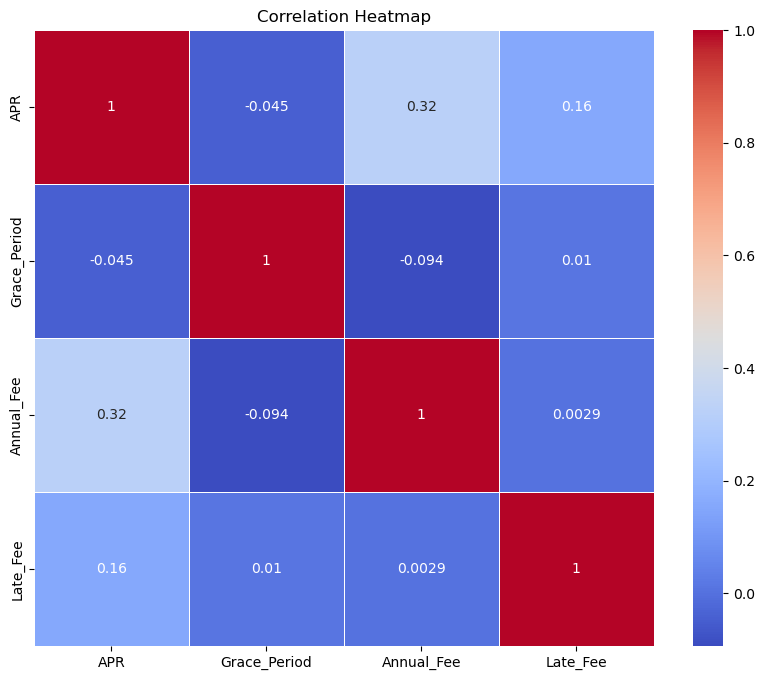

In [362]:
plt.figure(figsize=(10, 8))  # Set the figure size

# Create the heatmap
sns.heatmap(
    tccp.corr(),
    annot=True,  # Display values in each cell
    cmap='coolwarm',  # Choose a color map (e.g., 'viridis', 'coolwarm', 'YlGnBu', etc.)
    linewidths=0.5,  # Add gridlines between cells
)
plt.title('Correlation Heatmap')  # Set the heatmap title

plt.show()  # Display the heatmap

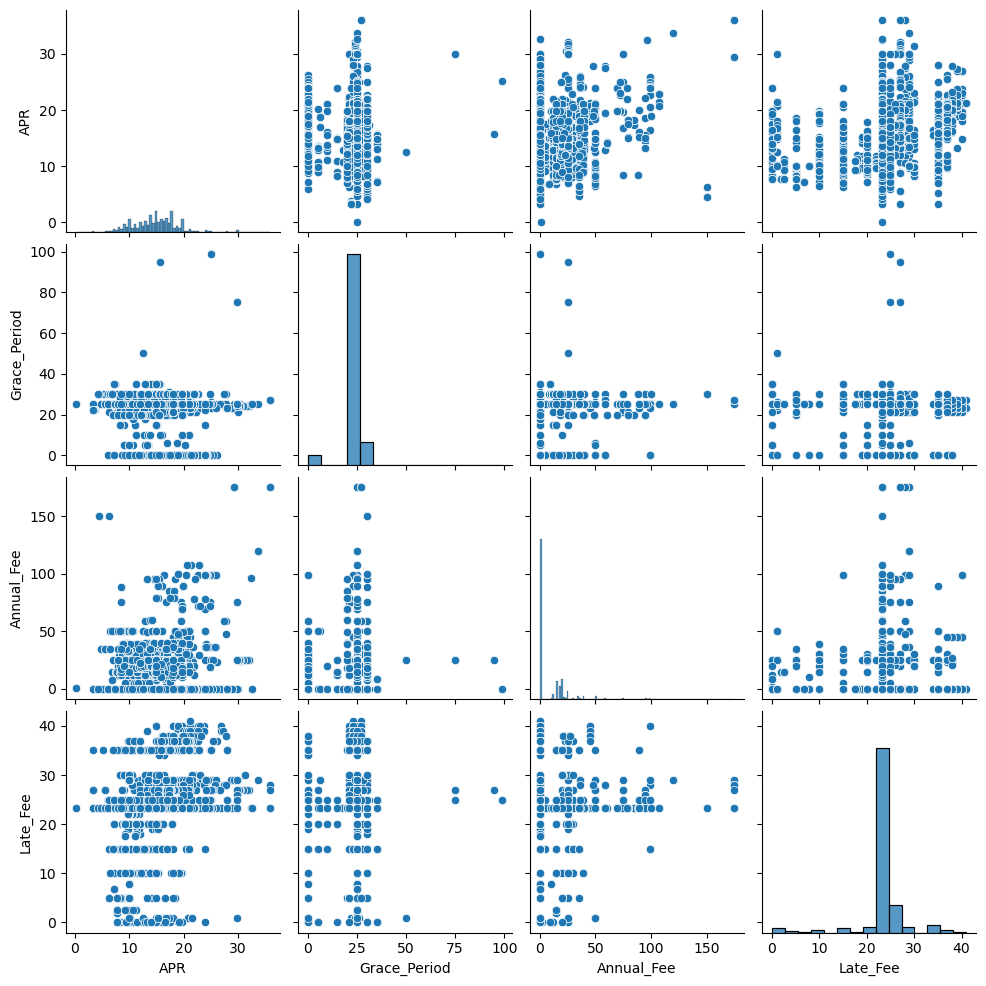

In [376]:
sns.pairplot(tccp)

<a id="apr-plots"></a>

---
## Plots on APR and different filters of APR
---

### APR Bands Over Course of Data Set: 1990 - 2023

In [274]:
apr_mean_ot = tccp.groupby(tccp['Agreement_Date'].dt.date)['APR'].mean()
apr_max_ot = tccp.groupby(tccp['Agreement_Date'].dt.date)['APR'].max()
apr_min_ot = tccp.groupby(tccp['Agreement_Date'].dt.date)['APR'].min()

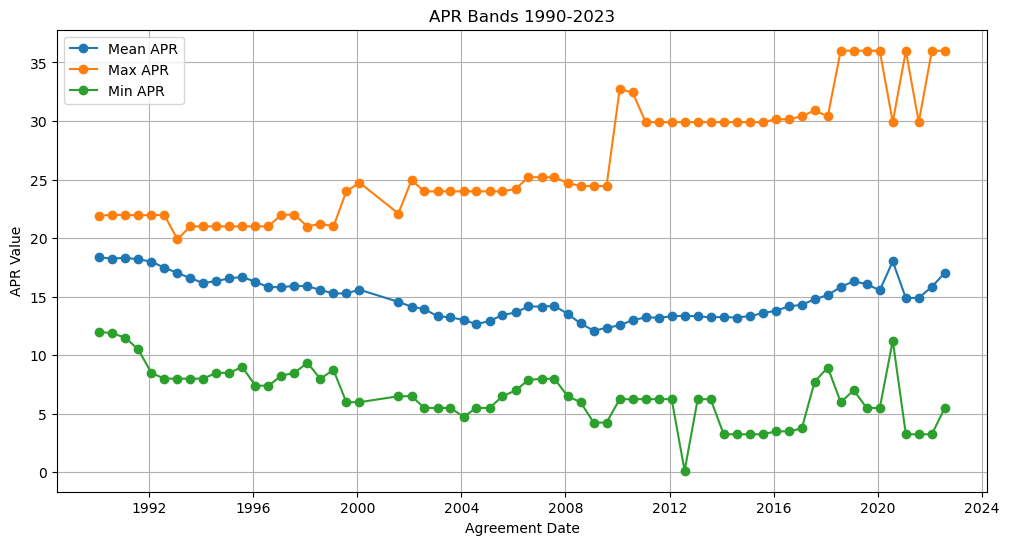

In [388]:
plt.figure(figsize=(12, 6))
apr_mean_ot.plot(kind="line",marker="o", linestyle="-", label="Mean APR")
apr_max_ot.plot(kind="line",marker="o", linestyle="-", label="Max APR")
apr_min_ot.plot(kind="line",marker="o", linestyle="-", label="Min APR")
plt.cm.viridis
plt.title("APR Bands 1990-2023")
plt.xlabel("Agreement Date")
plt.ylabel("APR Value")
plt.grid(True)
plt.legend()
plt.show()

### APR Bands 1990-2023 with Visa and Mastercard Mean APR

In [307]:
# Define regex patterns for variations of Mastercard and Visa
mastercard_pattern = re.compile(r'.*Mastercard.*', flags=re.IGNORECASE)
visa_pattern = re.compile(r'.*Visa.*', flags=re.IGNORECASE)

# Create separate DataFrames for Visa and Mastercard
visa_df = tccp[tccp['Plan_Name'].str.contains(visa_pattern)]
mastercard_df = tccp[tccp['Plan_Name'].str.contains(mastercard_pattern)]

# Group by Agreement_Date and calculate the mean APR for Visa and Mastercard
mean_apr_visa = visa_df.groupby(visa_df['Agreement_Date'].dt.date)['APR'].mean()
mean_apr_mastercard = mastercard_df.groupby(mastercard_df['Agreement_Date'].dt.date)['APR'].mean()


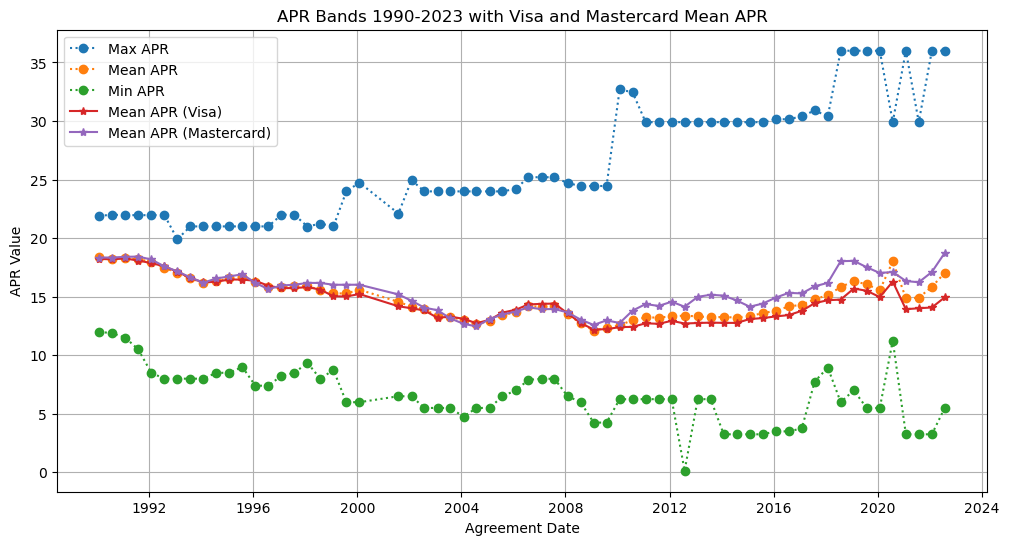

In [390]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
# Plot APR Lines
ax.plot(apr_max_ot, label="Max APR", marker="o", linestyle=":")
ax.plot(apr_mean_ot, label="Mean APR", marker="o", linestyle=":")
ax.plot(apr_min_ot, label="Min APR", marker="o", linestyle=":")
ax.plot(mean_apr_visa.index, mean_apr_visa.values, label="Mean APR (Visa)", marker="*", linestyle="-")
ax.plot(mean_apr_mastercard.index, mean_apr_mastercard.values, label="Mean APR (Mastercard)", marker="*", linestyle="-")
# Set labels and title
ax.set_xlabel("Agreement Date")
ax.set_ylabel("APR Value")
ax.set_title("APR Bands 1990-2023 with Visa and Mastercard Mean APR")

# Add legend
ax.legend()
plt.grid(True)

# Show the plot
plt.show()


- Over time the APR range has only widened, which is part of the problem statement, and guessing a number 1 complaint from User Advocates
- Plans that mention Visa or Mastercard in their name are co-linear with the mean APR over Time
- The mean looks to be more closely correlated with the mininum APR values over time. This to me means there's a higher percentage of values closer to the mininum value over the maximum value
- Good news is that for different scenarios (Region, Plan Names, others), the values are more or less evenly distributed and centered around the mean, this means that while the range is widening, most reported offers are middle ground.
- Bad news, according to the data dictionary, if the APR is variable by customer segment, the data is just recorded as the middle point of their offerings.

### Distribution of Values for Visa and Mastercard Plans

In [354]:
mean_visa_val = visa_df['APR'].mean()
visa_std_val = visa_df['APR'].std()
mean_mc_val = mastercard_df['APR'].mean()
mc_std_value = mastercard_df['APR'].std()

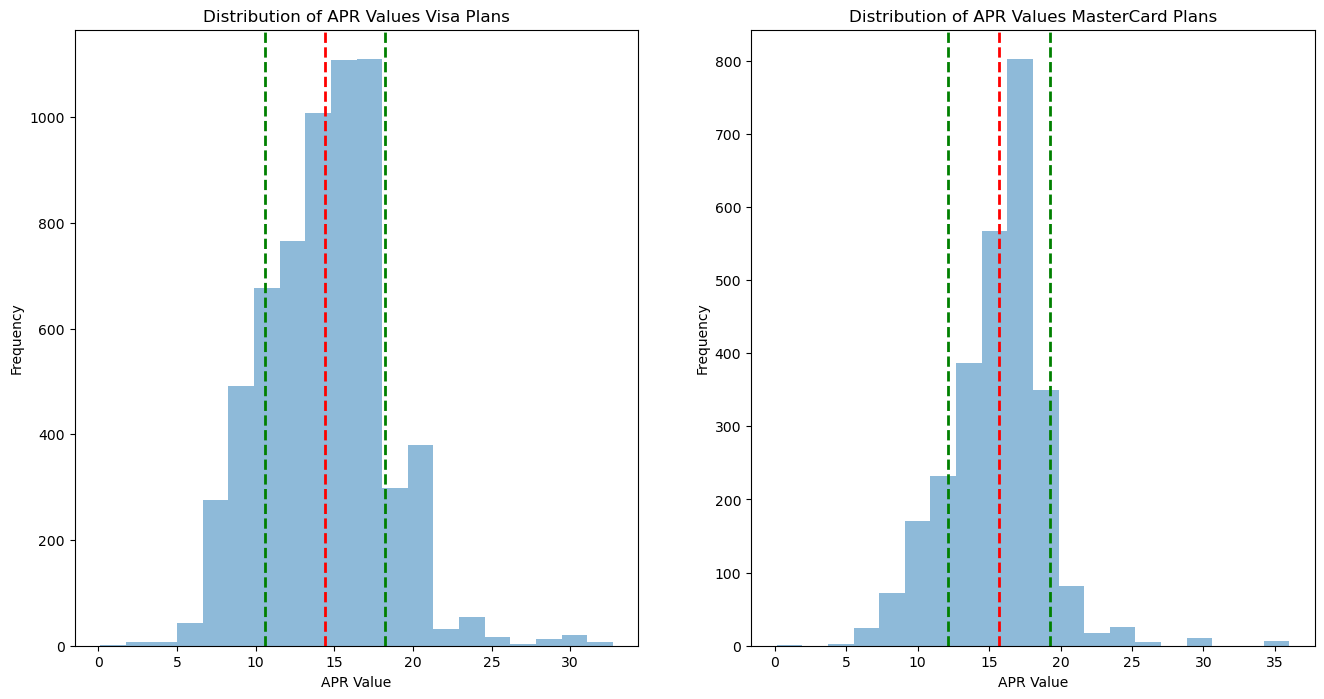

In [356]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the distribution of APR values
axes[0].hist(visa_df['APR'], bins=20, alpha=0.5, label="Visa Plans")
axes[0].axvline(mean_visa_val, color='r', linestyle='dashed', linewidth=2, label='Mean')
axes[0].axvline(mean_visa_val + visa_std_val, color='g', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
axes[0].axvline(mean_visa_val - visa_std_val, color='g', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')
axes[1].hist(mastercard_df['APR'], bins=20, alpha=0.5, label="Mastercard Plans")
axes[1].axvline(mean_mc_val, color='r', linestyle='dashed', linewidth=2, label='Mean')
axes[1].axvline(mean_mc_val + mc_std_value, color='g', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
axes[1].axvline(mean_mc_val - mc_std_value, color='g', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')

# Set labels and title
axes[0].set_xlabel("APR Value")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of APR Values Visa Plans")
axes[1].set_xlabel("APR Value")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of APR Values MasterCard Plans")

# Show the plot
plt.show()

### Attempting to Capture Credit Unions v. Big Name Brands

In [391]:
# Define regex patterns for variations of Union to capture credit union specific plans
union_pattern = re.compile(r'.*union.*', flags=re.IGNORECASE)
# Create separate DataFrames for union
union_df = tccp[tccp['Plan_Name'].str.contains(union_pattern)]
# Group by Agreement_Date and calculate the mean APR for Union
mean_apr_union = union_df.groupby(union_df['Agreement_Date'].dt.date)['APR'].mean()

In [394]:
union_inst_df = tccp[tccp['Institution_Name'].str.contains(union_pattern)]
mean_apr_inst_union = union_inst_df.groupby(union_inst_df['Agreement_Date'].dt.date)['APR'].mean()

In [401]:
union_df.shape,union_inst_df.shape

((32, 12), (852, 12))

### Credit Union by applying Regex pattern to Plan Name

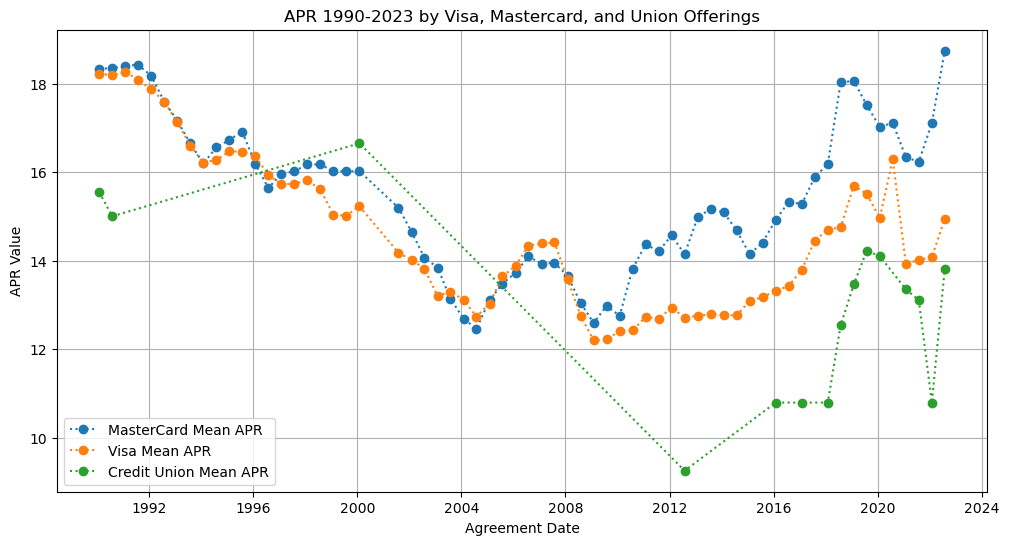

In [395]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
# Plot APR Lines
ax.plot(mean_apr_mastercard, label="MasterCard Mean APR", marker="o", linestyle=":")
ax.plot(mean_apr_visa, label="Visa Mean APR", marker="o", linestyle=":")
ax.plot(mean_apr_union, label="Credit Union Mean APR", marker="o", linestyle=":")
# Set labels and title
ax.set_xlabel("Agreement Date")
ax.set_ylabel("APR Value")
ax.set_title("APR 1990-2023 by Visa, Mastercard, and Union Offerings")

# Add legend
ax.legend()
plt.grid(True)

# Show the plot
plt.show()


### Credit Union by applying Regex pattern to Institution Name

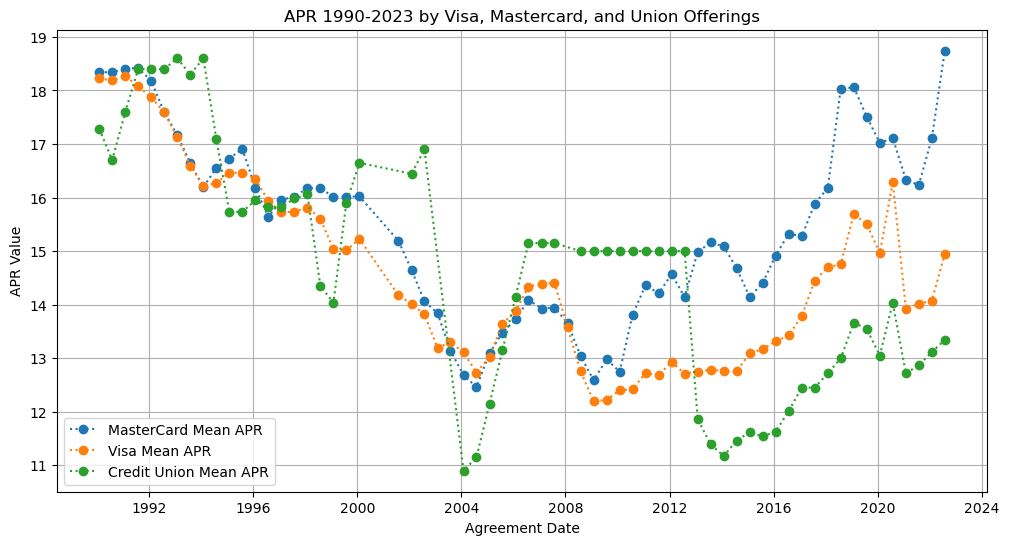

In [399]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
# Plot APR Lines
ax.plot(mean_apr_mastercard, label="MasterCard Mean APR", marker="o", linestyle=":")
ax.plot(mean_apr_visa, label="Visa Mean APR", marker="o", linestyle=":")
ax.plot(mean_apr_inst_union, label="Credit Union Mean APR", marker="o", linestyle=":")
# Set labels and title
ax.set_xlabel("Agreement Date")
ax.set_ylabel("APR Value")
ax.set_title("APR 1990-2023 by Visa, Mastercard, and Union Offerings")

# Add legend
ax.legend()
plt.grid(True)

# Show the plot
plt.show()


- Credit Union offered APRs are (at least from this data) much more variable than i was expecting.
- I was expecting much more of Credit Union Data from post 2012 to present, and was not expecting the credit union offerings to be higher than general plan offerings in previous years
- When we think about our problem and solution statements in regard to who is the biggest group/largest impact area population wise, keeping an eye on the range of offerings between these categories will be key

### APR by Geographic Availability

In [332]:
# Create separate DataFrames for Visa and Mastercard
regional_df = tccp[tccp['Availability_of_Credit_Card_Plan']=="Regional"]
national_df = tccp[tccp['Availability_of_Credit_Card_Plan']=="National"]
one_state_df = tccp[tccp['Availability_of_Credit_Card_Plan']=="One State"]

# Group by Agreement_Date and calculate the mean APR for Visa and Mastercard
mean_regional = regional_df.groupby(regional_df['Agreement_Date'].dt.date)['APR'].mean()
mean_national = national_df.groupby(national_df['Agreement_Date'].dt.date)['APR'].mean()
mean_one_state = one_state_df.groupby(one_state_df['Agreement_Date'].dt.date)['APR'].mean()


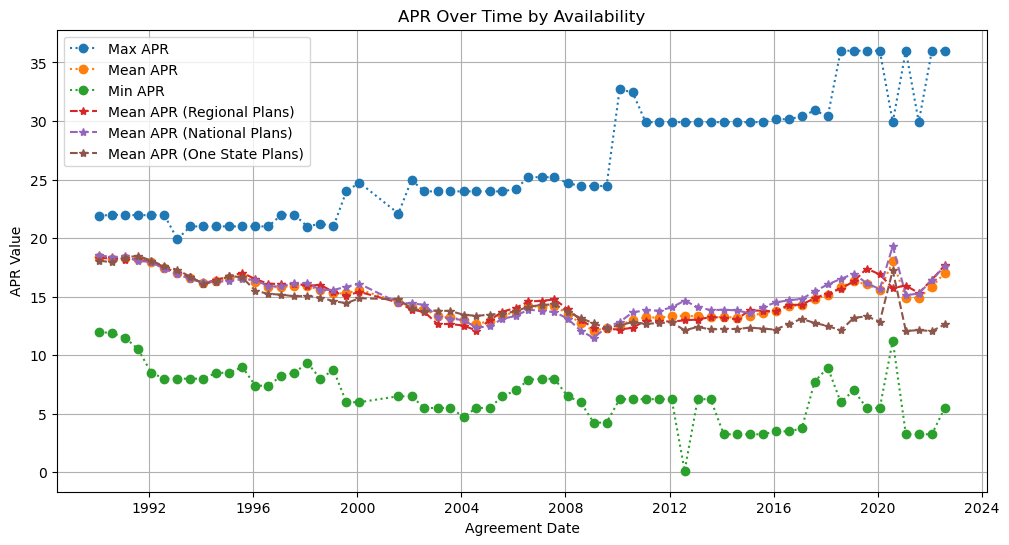

In [338]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
# Plot APR Lines
ax.plot(apr_max_ot, label="Max APR", marker="o", linestyle=":")
ax.plot(apr_mean_ot, label="Mean APR", marker="o", linestyle=":")
ax.plot(apr_min_ot, label="Min APR", marker="o", linestyle=":")
ax.plot(mean_regional.index, mean_regional.values, label="Mean APR (Regional Plans)", marker="*", linestyle="--")
ax.plot(mean_national.index, mean_national.values, label="Mean APR (National Plans)", marker="*", linestyle="--")
ax.plot(mean_one_state.index, mean_one_state.values, label="Mean APR (One State Plans)", marker="*", linestyle="--")
# Set labels and title
ax.set_xlabel("Agreement Date")
ax.set_ylabel("APR Value")
ax.set_title("APR Over Time by Availability")

# Add legend
ax.legend()
plt.grid(True)

# Show the plot
plt.show()


In [358]:
mean_regional_val = regional_df['APR'].mean()
std_regional_val = regional_df['APR'].std()
mean_national_val = national_df['APR'].mean()
std_national_value = national_df['APR'].std()
mean_os_val = one_state_df['APR'].mean()
std_os_value = one_state_df['APR'].std()

### APR by Availability Distributions

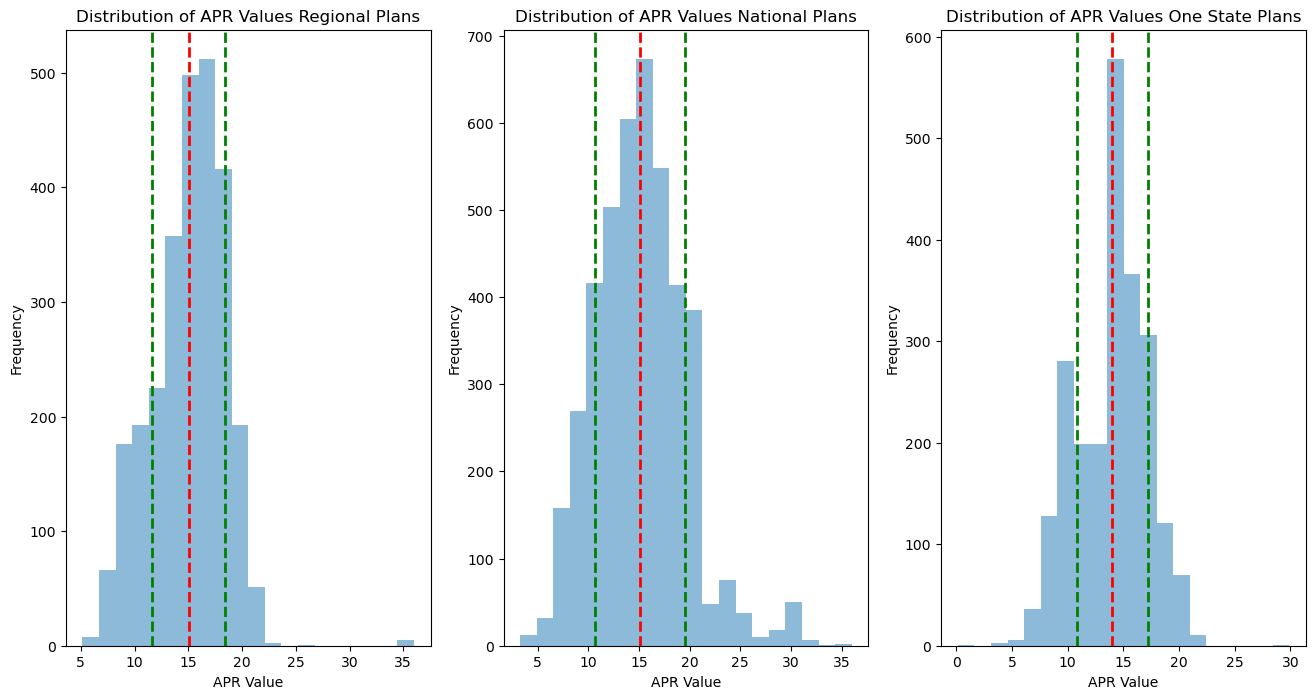

In [387]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

# Plot the distribution of APR values
axes[0].hist(regional_df['APR'], bins=20, alpha=0.5, label="Visa Plans")
axes[0].axvline(mean_regional_val, color='r', linestyle='dashed', linewidth=2, label='Mean')
axes[0].axvline(mean_regional_val + std_regional_val, color='g', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
axes[0].axvline(mean_regional_val - std_regional_val, color='g', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')
axes[1].hist(national_df['APR'], bins=20, alpha=0.5, label="Mastercard Plans")
axes[1].axvline(mean_national_val, color='r', linestyle='dashed', linewidth=2, label='Mean')
axes[1].axvline(mean_national_val + std_national_value, color='g', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
axes[1].axvline(mean_national_val - std_national_value, color='g', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')
axes[2].hist(one_state_df['APR'], bins=20, alpha=0.5, label="Mastercard Plans")
axes[2].axvline(mean_os_val, color='r', linestyle='dashed', linewidth=2, label='Mean')
axes[2].axvline(mean_os_val + std_os_value, color='g', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
axes[2].axvline(mean_os_val - std_os_value, color='g', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')

# Set labels and title
axes[0].set_xlabel("APR Value")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of APR Values Regional Plans")
axes[1].set_xlabel("APR Value")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of APR Values National Plans")
axes[2].set_xlabel("APR Value")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of APR Values One State Plans")

# Show the plot
plt.show()

### APR v. Annual Fee values Scatterplot

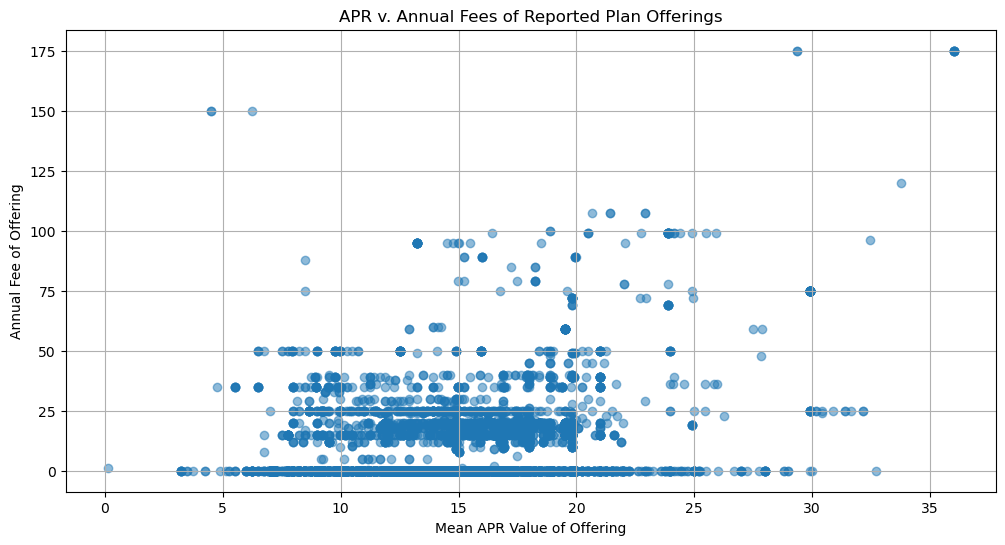

In [523]:
plt.figure(figsize=(12, 6))
plt.scatter(tccp['APR'], tccp['Annual_Fee'], alpha=0.5)
plt.title("APR v. Annual Fees of Reported Plan Offerings")
plt.xlabel("Mean APR Value of Offering")
plt.ylabel("Annual Fee of Offering")
plt.grid(True)
plt.show()

### APR v. Index (Variable or Fixed) Scatter

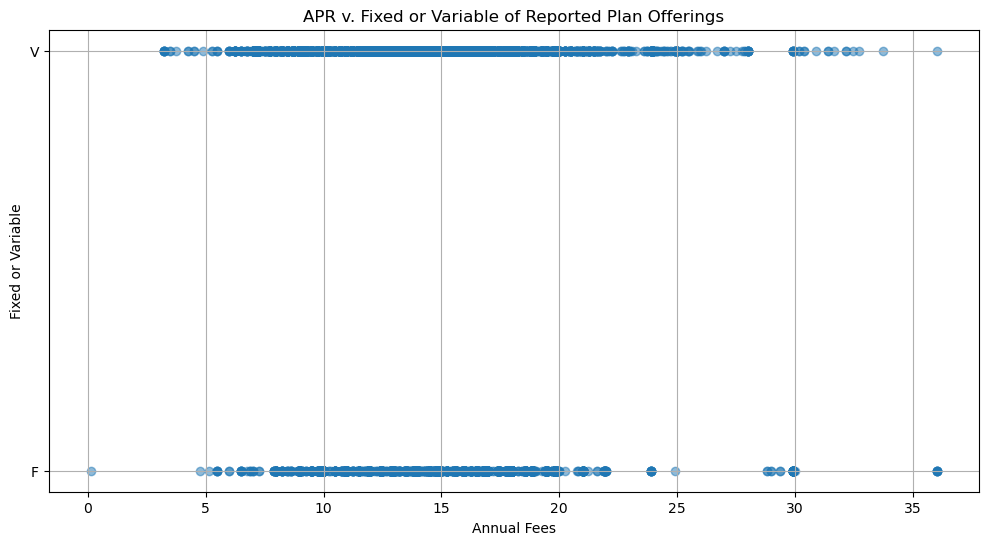

In [400]:
plt.figure(figsize=(12, 6))
plt.scatter(tccp['APR'], tccp['Index'], alpha=0.5)
plt.title("APR v. Fixed or Variable of Reported Plan Offerings")
plt.xlabel("Annual Fees")
plt.ylabel("Fixed or Variable")
plt.grid(True)
plt.show()

### APR v. Variable Rate Index Instrument

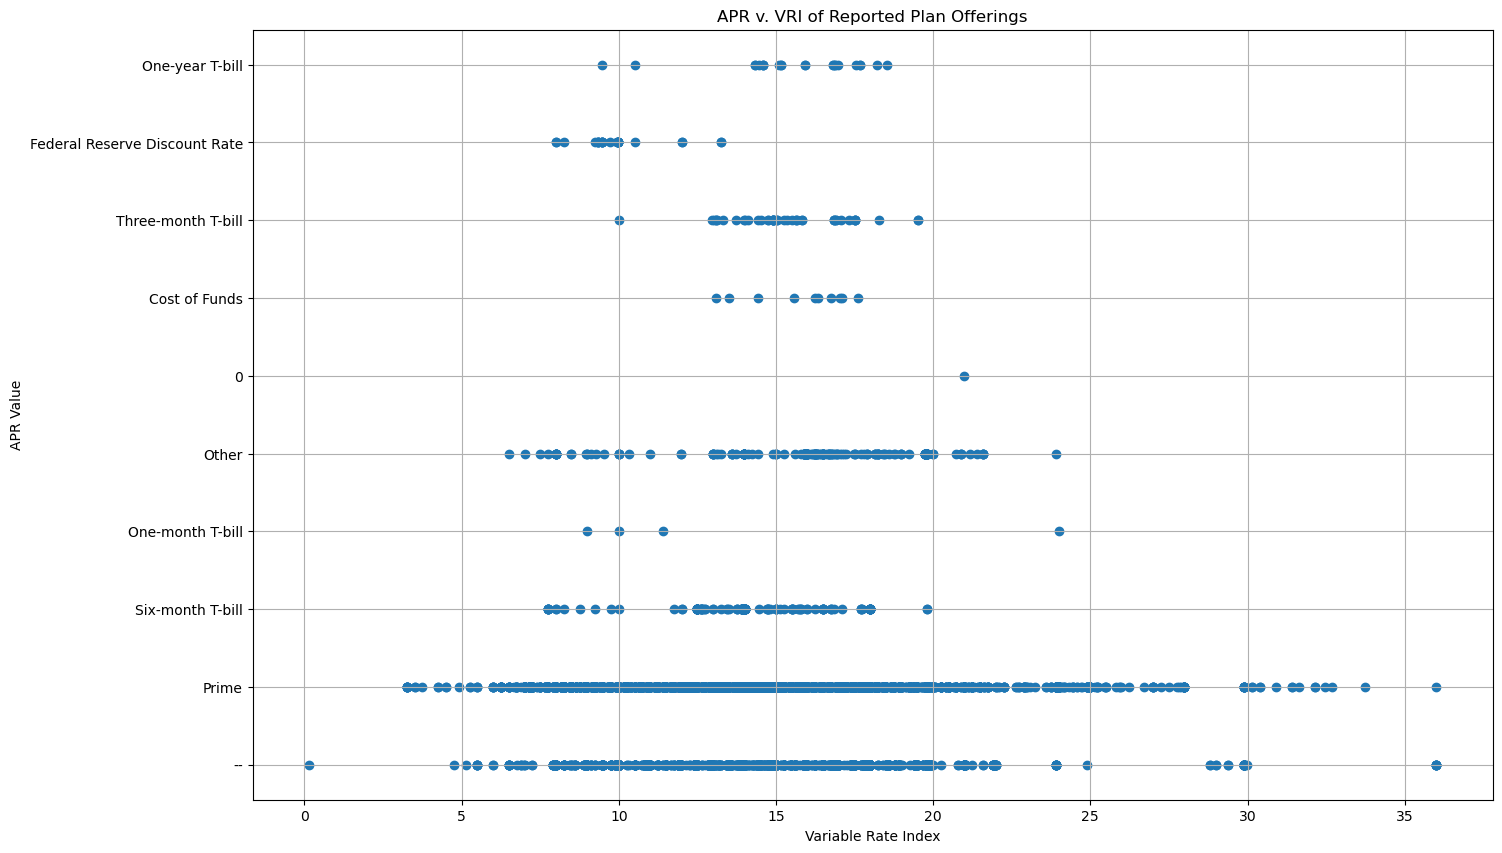

In [380]:
plt.figure(figsize=(16, 10))
plt.scatter(tccp['APR'], tccp['Variable_Rate_Index'])
plt.title("APR v. VRI of Reported Plan Offerings")
plt.xlabel("Variable Rate Index")
plt.ylabel("APR Value")
plt.grid(True)
plt.show()

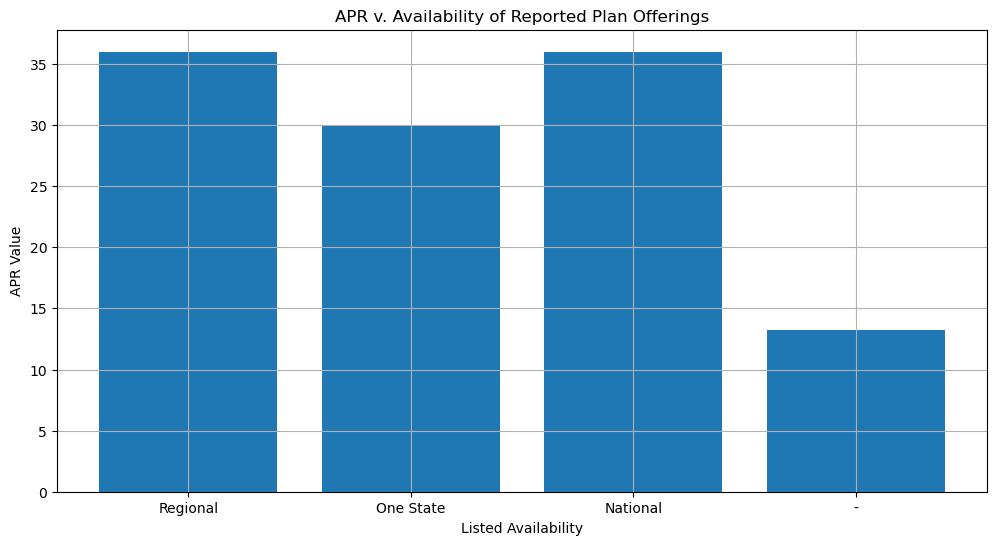

In [375]:
plt.figure(figsize=(12, 6))
plt.bar(tccp['Availability_of_Credit_Card_Plan'],tccp['APR'])
plt.title("APR v. Availability of Reported Plan Offerings")
plt.xlabel("Listed Availability")
plt.ylabel("APR Value")
plt.grid(True)
plt.show()

## What can Lending volumes of aggregate dollar of new credit cards tell us?

In [404]:
lending_df = pd.read_csv("../data/CFPB_Lending_Levels.csv")

Blessing no obvious clean needed, no nulls and everything seems in order Dtype wise (except date as usual)

In [408]:
lending_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   month               860 non-null    int64         
 1   date                860 non-null    datetime64[ns]
 2   vol                 860 non-null    float64       
 3   vol_unadj           860 non-null    int64         
 4   credit_score_group  860 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 33.7+ KB


In [406]:
lending_df.head()

,month,date,vol,vol_unadj,credit_score_group
0,60,2005-01,1.975251e+09,1681651504,Near-prime
1,60,2005-01,2.552987e+10,22175084200,Super-prime
2,60,2005-01,3.111538e+08,248828840,Deep subprime
3,60,2005-01,6.297436e+08,513599552,Subprime
4,60,2005-01,7.968594e+09,6980703344,Prime


|Feature|Type|Description|
|:---|:---:|:---:|
|**month**|*int64*|serves as an index of months in the date column, starts at 60 for January, 2005|
|**date**|*datetime64[ns]*|Year and Month of the reported volume per credit score group|
|**vol**|*float64*|Volume of credit card origination in Billions of dollars|
|**vol_unadj**|*int64*|Pure volume of credit card origination in Billions of dollars|
|**credit_score_group**|*object*|Classification label of where your credit score places your distance from the prime rate.|

In [468]:
lending_df["date"] = pd.to_datetime(lending_df["date"])

In [409]:
lending_df.head()

,month,date,vol,vol_unadj,credit_score_group
0,60,2005-01-01,1.975251e+09,1681651504,Near-prime
1,60,2005-01-01,2.552987e+10,22175084200,Super-prime
2,60,2005-01-01,3.111538e+08,248828840,Deep subprime
3,60,2005-01-01,6.297436e+08,513599552,Subprime
4,60,2005-01-01,7.968594e+09,6980703344,Prime


In [412]:
lending_df[lending_df["date"]=='2005-07']

,month,date,vol,vol_unadj,credit_score_group
30,66,2005-07-01,2.149897e+09,2136943832,Near-prime
31,66,2005-07-01,2.414170e+10,24613691760,Super-prime
32,66,2005-07-01,4.304755e+08,407983040,Deep subprime
33,66,2005-07-01,7.521273e+08,756611200,Subprime
34,66,2005-07-01,7.930566e+09,7994912080,Prime


In [436]:
# get the min and max dates of the lending volume dataframe
lending_df["date"].min(),lending_df["date"].max()

(Timestamp('2005-01-01 00:00:00'), Timestamp('2019-04-01 00:00:00'))

In [437]:
# set a pandas mask i.e. filter criteria to pull information between the min and max dates of the lending df
mask = (tccp["Agreement_Date"] > lending_df["date"].min()) & (tccp["Agreement_Date"] < lending_df["date"].max())

In [438]:
tccp_lending_range = tccp.loc[mask]

In [439]:
tccp_lending_range.head()

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
814,2019-01-31,KEYBANK NATIONAL ASSOCIATION,Key2More Rewards MasterCard,Regional,AK; CO; CT; FL; ID; IN; ME; MA; NY; OH; OR; PA...,20.24,V,Prime,28.0,0.0,27.0,(800) 539-2968
815,2019-01-31,WINGS FINANCIAL CREDIT UNION,Visa Platinum,National,National,13.33,V,Prime,25.0,0.0,27.0,(866) 820-3925
816,2019-01-31,"VIRGINIA CREDIT UNION, INC.",Mastercard,National,National,16.49,V,Prime,25.0,0.0,35.0,(800) 285-5051
817,2019-01-31,USAA SAVINGS BANK,Visa,National,National,18.40,V,Prime,25.0,0.0,25.0,(800) 531-8722
818,2019-01-31,U.S. Bank,Visa Platinum,National,National,19.99,V,Prime,30.0,0.0,27.0,(800) 285-8585


In [440]:
tccp_lending_range['Agreement_Date'] = tccp_lending_range['Agreement_Date'].dt.strftime('%Y-%m')

/var/folders/6y/v5glmyqn4txdzjjjjdn0r32w0000gn/T/ipykernel_31875/3033670822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tccp_lending_range['Agreement_Date'] = tccp_lending_range['Agreement_Date'].dt.strftime('%Y-%m')


In [442]:
# changed date format to yyyy-mm for easier co-plotting
tccp_lending_range.head(1)

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
814,2019-01,KEYBANK NATIONAL ASSOCIATION,Key2More Rewards MasterCard,Regional,AK; CO; CT; FL; ID; IN; ME; MA; NY; OH; OR; PA...,20.24,V,Prime,28.0,0.0,27.0,(800) 539-2968


In [443]:
lending_df['date'] = lending_df['date'].dt.strftime('%Y-%m')

In [449]:
lending_df.head(5)

,month,date,vol,vol_unadj,credit_score_group
0,60,2005-01,1.975251e+09,1681651504,Near-prime
1,60,2005-01,2.552987e+10,22175084200,Super-prime
2,60,2005-01,3.111538e+08,248828840,Deep subprime
3,60,2005-01,6.297436e+08,513599552,Subprime
4,60,2005-01,7.968594e+09,6980703344,Prime


In [455]:
tccp_lending_range.head()

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers
814,2019-01-01,KEYBANK NATIONAL ASSOCIATION,Key2More Rewards MasterCard,Regional,AK; CO; CT; FL; ID; IN; ME; MA; NY; OH; OR; PA...,20.24,V,Prime,28.0,0.0,27.0,(800) 539-2968
815,2019-01-01,WINGS FINANCIAL CREDIT UNION,Visa Platinum,National,National,13.33,V,Prime,25.0,0.0,27.0,(866) 820-3925
816,2019-01-01,"VIRGINIA CREDIT UNION, INC.",Mastercard,National,National,16.49,V,Prime,25.0,0.0,35.0,(800) 285-5051
817,2019-01-01,USAA SAVINGS BANK,Visa,National,National,18.40,V,Prime,25.0,0.0,25.0,(800) 531-8722
818,2019-01-01,U.S. Bank,Visa Platinum,National,National,19.99,V,Prime,30.0,0.0,27.0,(800) 285-8585


In [456]:
tccp_lending_range.groupby(tccp_lending_range['Agreement_Date'].dt.date)['APR'].mean()

Agreement_Date
2005-01-01    12.933624
2005-07-01    13.424722
2006-01-01    13.657482
2006-07-01    14.162237
2007-01-01    14.157086
2007-07-01    14.206000
2008-01-01    13.540993
2008-07-01    12.713179
2009-01-01    12.097895
2009-07-01    12.336218
2010-01-01    12.552625
2010-07-01    13.001250
2011-01-01    13.223618
2011-07-01    13.219388
2012-01-01    13.314698
2012-07-01    13.386074
2013-01-01    13.311342
2013-07-01    13.245185
2014-01-01    13.263184
2014-07-01    13.215707
2015-01-01    13.344713
2015-07-01    13.589050
2016-01-01    13.799193
2016-07-01    14.162945
2017-01-01    14.310362
2017-07-01    14.774032
2018-01-01    15.141905
2018-07-01    15.824086
2019-01-01    16.320943
Name: APR, dtype: float64

In [457]:
lending_df

,month,date,vol,vol_unadj,credit_score_group
0,60,2005-01,1.975251e+09,1681651504,Near-prime
1,60,2005-01,2.552987e+10,22175084200,Super-prime
2,60,2005-01,3.111538e+08,248828840,Deep subprime
3,60,2005-01,6.297436e+08,513599552,Subprime
4,60,2005-01,7.968594e+09,6980703344,Prime
...,...,...,...,...,...
855,231,2019-04,1.654587e+09,1607217888,Near-prime
856,231,2019-04,2.594233e+10,25824449859,Super-prime
857,231,2019-04,2.834872e+08,270834734,Deep subprime
858,231,2019-04,5.533416e+08,545378790,Subprime


In [465]:
tccp_lending_range['Year'] = tccp_lending_range['Agreement_Date'].dt.year

/var/folders/6y/v5glmyqn4txdzjjjjdn0r32w0000gn/T/ipykernel_31875/727727229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tccp_lending_range['Year'] = tccp_lending_range['Agreement_Date'].dt.year


In [469]:
lending_df['year'] = lending_df['date'].dt.year

In [470]:
tccp_lending_range.head(1)

,Agreement_Date,Institution_Name,Plan_Name,Availability_of_Credit_Card_Plan,Location,APR,Index,Variable_Rate_Index,Grace_Period,Annual_Fee,Late_Fee,Telephone_Number_for_Consumers,YearMonth,Year
814,2019-01-01,KEYBANK NATIONAL ASSOCIATION,Key2More Rewards MasterCard,Regional,AK; CO; CT; FL; ID; IN; ME; MA; NY; OH; OR; PA...,20.24,V,Prime,28.0,0.0,27.0,(800) 539-2968,2019-01,2019


In [500]:
lending_df.head(1)

,month,date,vol,vol_unadj,credit_score_group,year
0,60,2005-01-01,1.975251e+09,1681651504,Near-prime,2005


<a id="supplemental"></a>

## Mean APR v. Mean Origination Volume (Billions USD)

In [486]:
mean_apr_agreement = tccp_lending_range.groupby("Agreement_Date")['APR'].mean()

In [501]:
mean_vol_lending = lending_df.groupby('date')['vol'].mean()

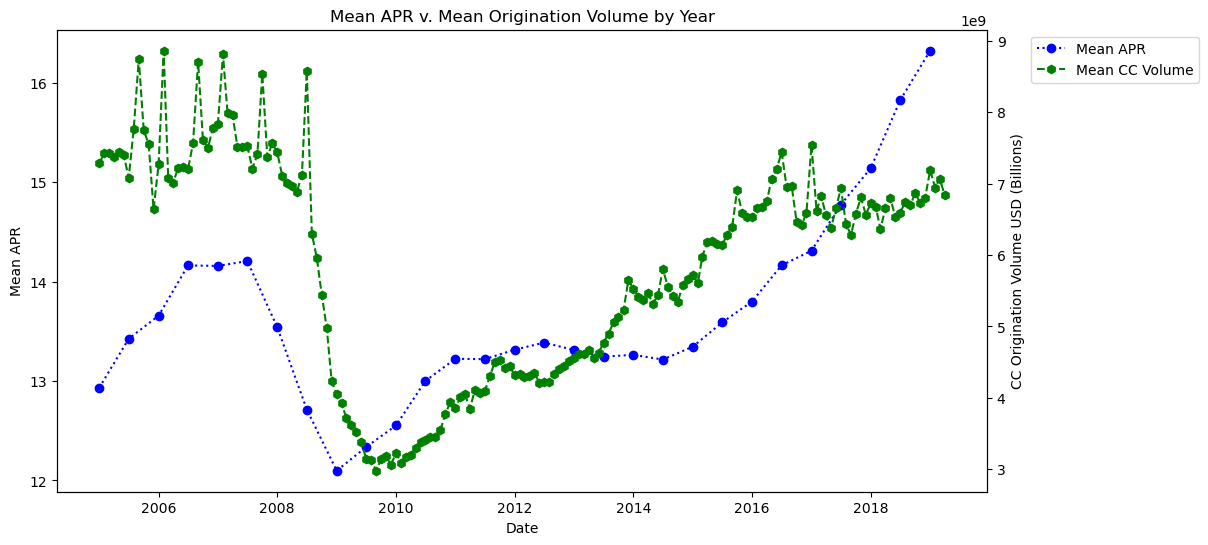

In [503]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(mean_apr_agreement, label="Mean APR", color='b', marker="o", linestyle=":")
ax1.set_xlabel("Date")
ax1.set_ylabel("Mean APR")

ax2 = ax1.twinx()
ax2.plot(mean_vol_lending, label="Mean CC Volume", color='g', marker="h", linestyle="--")
ax2.set_ylabel("CC Origination Volume USD (Billions)")

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.04, 1))
plt.title("Mean APR v. Mean Origination Volume by Year");

In [504]:
mean_vol_lending_score_groups = lending_df.groupby(['date','credit_score_group'])['vol'].mean()

In [505]:
mean_vol_lending_score_groups.unstack()

credit_score_group,Deep subprime,Near-prime,Prime,Subprime,Super-prime
date,,,,,
2005-01-01,3.111538e+08,1.975251e+09,7.968594e+09,6.297436e+08,2.552987e+10
2005-02-01,3.270322e+08,2.097046e+09,8.091674e+09,7.332538e+08,2.590868e+10
2005-03-01,3.290795e+08,2.120043e+09,8.315320e+09,6.648996e+08,2.573525e+10
2005-04-01,3.152164e+08,2.100221e+09,8.222139e+09,6.526290e+08,2.556953e+10
2005-05-01,3.325128e+08,2.048704e+09,8.286362e+09,1.141957e+09,2.543433e+10
...,...,...,...,...,...
2018-12-01,2.706484e+08,1.528429e+09,5.984406e+09,5.116564e+08,2.568563e+10
2019-01-01,2.861973e+08,1.593110e+09,5.943814e+09,5.477179e+08,2.757334e+10
2019-02-01,2.662350e+08,1.655812e+09,6.090807e+09,5.339354e+08,2.616626e+10


In [511]:
mvlsg = mean_vol_lending_score_groups.unstack()

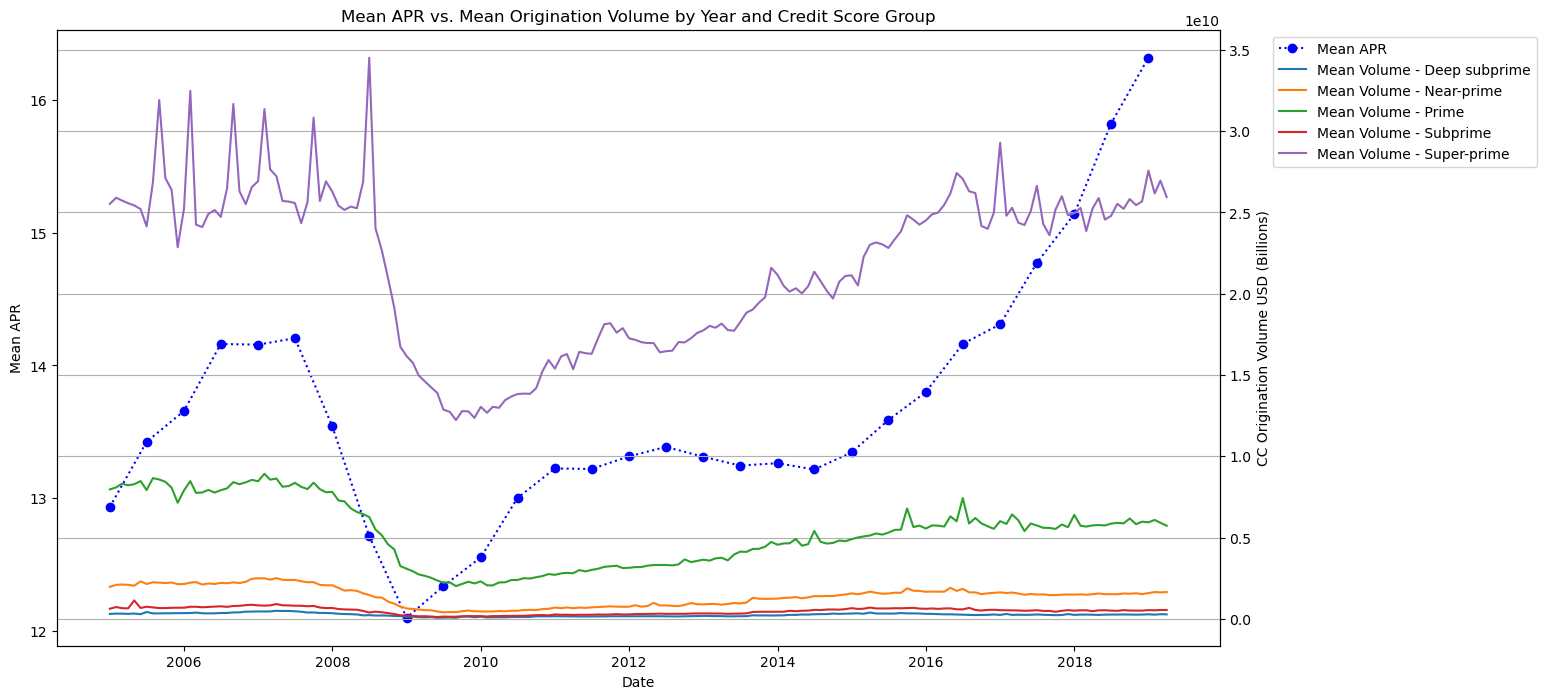

In [516]:
# Create a dual y-axis plot
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.plot(mean_apr_agreement, label="Mean APR", color='b', marker="o", linestyle=":")
ax1.set_xlabel("Date")
ax1.set_ylabel("Mean APR")

ax2 = ax1.twinx()

# Plot the mean origination volume for each credit_score_group
for column in mvlsg.columns:
    ax2.plot(mvlsg.index, mvlsg[column], label=f"Mean Volume - {column}")

ax2.set_ylabel("CC Origination Volume USD (Billions)")

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.04, 1))
plt.title("Mean APR vs. Mean Origination Volume by Year and Credit Score Group")

# Show the plot
plt.grid(visible=True)
plt.show()


<a href="https://www.investopedia.com/terms/p/primerate.asp">Investopedia</a>
- The prime rate is the interest rate that commercial banks charge their most creditworthy customers.
- The Federal Reserve System sets the federal funds overnight rate which serves as the basis for the prime rate, which is the starting point for other interest rates
    - Based on the federal funds rate, banks generally use fed funds + 3 bp to determine the current prime rate
    - Lenders generally charge the most creditworth clients the prime rate while others receive an interest rate based on their credit score of prime, plus another percentage
- The prime rate is the most commonly used benchmark used by banks and other lenders when setting their interest rates for various products such as credit cards and home loans

- Identifying relationships between APR and the metrics that move with it is proving difficult and baffling.
    - for example, looking at the above, I had assumed that when APR decreased, it would be due to competition in the market, the lower the rates the more appetizing for consumers of all bands
    - as such I would also expect that when apr reduced, origination volume would in turn rise
    - After thinking further, the above is too small of thought because their are wider economic conditions, as such let's look at origination volume in comparison with the fed funds rate, which as above is used as a benchmark for the prime rate

In [5]:
fedfunds_df = pd.read_excel("../data/fedfunds.xlsx")

/Users/christopherjoyce/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [6]:
fedfunds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3830 entries, 0 to 3829
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Effective Date            3830 non-null   object 
 1   Rate Type                 3830 non-null   object 
 2   Rate (%)                  3830 non-null   float64
 3   1st Percentile (%)        1026 non-null   float64
 4   25th Percentile (%)       1026 non-null   float64
 5   75th Percentile (%)       1026 non-null   float64
 6   99th Percentile (%)       1026 non-null   float64
 7   Volume ($Billions)        1026 non-null   float64
 8   Target Rate From (%)      3580 non-null   float64
 9   Target Rate To (%)        2586 non-null   float64
 10  Intra Day - Low (%)       2804 non-null   float64
 11  Intra Day - High (%)      2804 non-null   float64
 12  Standard Deviation (%)    2804 non-null   float64
 13  30-Day Average SOFR       0 non-null      float64
 14  90-Day A

For simplicity sakes we'll just take effective date, rate type and rate columns

In [11]:
fedfunds_df = fedfunds_df.loc[:,["Effective Date", "Rate Type", "Rate (%)"]]

In [12]:
fedfunds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3830 entries, 0 to 3829
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Effective Date  3830 non-null   object 
 1   Rate Type       3830 non-null   object 
 2   Rate (%)        3830 non-null   float64
dtypes: float64(1), object(2)
memory usage: 89.9+ KB


In [517]:
# merged_df = pd.merge(tccp_lending_range, lending_df, left_on='Year', right_on='year', how='inner')

<a id="product"></a>

## Product

- <a href="https://www.ifac.org/knowledge-gateway/contributing-global-economy/discussion/cost-financial-illiteracy#:~:text=The%20average%20estimated%20amount%20of,than%20%24436%20billion%20in%202022.">Financial Illiteracy in United States</a>
- <a href="https://www.ftc.gov/news-events/news/press-releases/2022/05/ftc-shuts-down-credit-repair-pyramid-scheme-financial-education-services-which-bilked-more-213#:~:text=The%20Federal%20Trade%20Commission%20has,of%20more%20than%20%24213%20million.">Credit Environment</a>

Questions to explore:
- Given the information available, can we identify strong factors to conditions changing and apr increasing or decreasing
- Multivariable linear regression prediction problem of predicting a continuous variable
- Borrower Profile

## An Attempt at GANs

<a href="https://www.youtube.com/watch?v=ROLugVqjf00">GANs for Financial Time Series</a>

### Networks and Graph Database